In [82]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This notebook reads the data in pdiot_data/2021, removes recordings that are too small, and creates sliding windows of the recordings. These are then saved into ../data/sliding_windows_sizeX_stepX

## Getting the data

In [83]:
data_path = '../pdiot-data/2021/'

In [84]:
base_df = pd.DataFrame()

# Get a list of all respeck files in all the student folders
all_files = []
for f in os.listdir(data_path):
    if os.path.isdir(data_path + '/' + f):
        files = os.listdir(data_path + '/' + f)
        files = [data_path + '/' + f + '/' + f2 for f2 in files if 'Respeck' in f2]
        all_files += files
        
# Load them all into a df
for filename in all_files:
    #full_path = f"{clean_data_folder}/{filename}"
    #print(full_path)
    
    # load data into a DataFrame
    new_df = pd.read_csv(filename)
    
    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])

In [85]:
# We want to remove any falling recordings over 700 datapoints as this suggests that it contains falling + getting up
# We also want to remove any recordings less than the window size

In [86]:
smallest_window_size = 20
s = base_df.groupby('recording_id').size() >= smallest_window_size

filtered_df = base_df[base_df['recording_id'].isin(s.keys()[s])]

# Remove falling recordings longer than 700
s = filtered_df[filtered_df['activity_type'].str.contains('Falling')].groupby('recording_id').size() >= 700

filtered_df = filtered_df[~filtered_df['recording_id'].isin(s.keys()[s])]

# s1702583 has really inconsistent activity naming - remove
filtered_df = filtered_df[filtered_df['subject_id'] != 's1702583']

In [87]:
# Check that other people named correctly
filtered_df[filtered_df.apply(lambda x: not(x.activity_type in x.recording_id or x.activity_type.replace(' ', '_') in x.recording_id), axis=1)]

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id


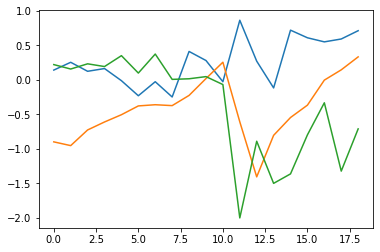

In [88]:
def plot_by_id(i): 
    plot_recording = base_df[base_df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id('Respeck_s1541031_Falling on knees_06-10-2021_15-46-54')

In [89]:
#base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values().head(40)
filtered_df.groupby('recording_id').size().sort_values().head(40)

recording_id
Respeck_s1865457_Falling on the left_30-09-2021_11-54-24     20
Respeck_s1865457_Falling on knees_30-09-2021_10-52-18        20
Respeck_s1865457_Falling on the right_30-09-2021_11-58-53    20
Respeck_s1865457_Falling on knees_30-09-2021_10-57-12        20
Respeck_s1865457_Falling on knees_30-09-2021_11-00-39        20
Respeck_s1865457_Falling on knees_30-09-2021_11-00-44        20
Respeck_s1865457_Falling on the back_30-09-2021_11-50-18     20
Respeck_s1865457_Falling on the right_30-09-2021_11-59-05    20
Respeck_s2192970_Falling on the right_06-10-2021_21-07-06    20
Respeck_s2211228_Falling on the left_06-10-2021_23-51-52     20
Respeck_s1865457_Falling on the back_30-09-2021_11-52-36     20
Respeck_s1842093_Falling on knees_05-10-2021_19-15-12        20
Respeck_s1870467_Falling on the left_05-10-2021_09-35-15     20
Respeck_s1842093_Falling on knees_05-10-2021_19-14-40        20
Respeck_s2192970_Falling on the right_06-10-2021_21-07-00    20
Respeck_s1865457_Falling on

## Preparing the sliding windows

In [90]:
filtered_df['activity_type'].unique()

array(['Climbing stairs', 'Descending stairs', 'Desk work',
       'Falling on knees', 'Falling on the back', 'Falling on the left',
       'Falling on the right', 'Lying down left', 'Lying down on back',
       'Lying down on stomach', 'Lying down right', 'Movement', 'Running',
       'Sitting bent backward', 'Sitting bent forward', 'Sitting',
       'Standing', 'Walking at normal speed'], dtype=object)

In [91]:
#activities_of_interest = ['Standing', 'Walking at normal speed']
activities_of_interest = filtered_df['activity_type'].unique()

In [92]:
window_size = smallest_window_size # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = smallest_window_size # 25 is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in filtered_df.groupby("recording_id"):
    if group['activity_type'].iloc[0] in activities_of_interest:
    
        print(f"Processing rid = {rid}")

        large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

        overlapping_windows = large_enough_windows[::step_size] 

        # then we will append a window ID to each window
        for window in overlapping_windows:
            window.loc[:, 'window_id'] = window_number
            window_number += 1

        #print(overlapping_windows)

        all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

Processing rid = Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43
Processing rid = Respeck_s1541031_Descending stairs_06-10-2021_11-25-05


C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Processing rid = Respeck_s1541031_Desk work_06-10-2021_11-04-49
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-46-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-02
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-13
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-20
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-25
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-30
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-35
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-39
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-48
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-52
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-56
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-48-00
Processing ri

Processing rid = Respeck_s1704145_Falling on the right_05-10-2021_13-02-31
Processing rid = Respeck_s1704145_Falling on the right_05-10-2021_13-02-41
Processing rid = Respeck_s1704145_Falling on the right_05-10-2021_13-03-08
Processing rid = Respeck_s1704145_Lying down left_23-09-2021_11-40-54
Processing rid = Respeck_s1704145_Lying down on back_23-09-2021_11-42-59
Processing rid = Respeck_s1704145_Lying down on stomach_05-10-2021_18-36-31
Processing rid = Respeck_s1704145_Lying down right_23-09-2021_11-41-34
Processing rid = Respeck_s1704145_Movement_23-09-2021_11-45-40
Processing rid = Respeck_s1704145_Running_23-09-2021_11-31-45
Processing rid = Respeck_s1704145_Sitting bent backward_23-09-2021_11-39-14
Processing rid = Respeck_s1704145_Sitting bent forward_23-09-2021_11-38-32
Processing rid = Respeck_s1704145_Sitting_23-09-2021_11-37-46
Processing rid = Respeck_s1704145_Standing_23-09-2021_11-40-05
Processing rid = Respeck_s1704145_Walking at normal speed_23-09-2021_11-32-29
Proces

Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-03
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-10
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-16
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-21
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-30
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-36
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-42
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-47
Processing rid = Respeck_s1711661_Falling on the right_24-09-2021_21-42-19
Processing rid = Respeck_s1711661_Falling on the right_24-09-2021_21-42-27
Processing rid = Respeck_s1711661_Falling on the right_24-09-2021_21-42-33
Processing rid = Respeck_s1711661_Falling on the right_24-09-2021_21-44-06
Processing rid = Respeck_s1711661_Falling on the right_24-09-2021_21-44-12
Processing rid = Respeck_s1711661

Processing rid = Respeck_s1721256_Standing_01-10-2021_19-00-30
Processing rid = Respeck_s1721256_Walking at normal speed_02-10-2021_22-12-45
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-23
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-35
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-51
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-41-02
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-41-14
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-41-46
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-41-56
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-42-07
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-42-19
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-42-30
Processing rid = Respeck_s1724067_Descending stairs_06-10-2021_19-44-10
Processing rid = Respeck_s1724067_Descending stairs_06-10-2021_19-44-19
Processing rid 

Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-54-47
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-06
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-18
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-30
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-40
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-02
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-12
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-20
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-28
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-36
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-44
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-57-05
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-57-20
Processing rid = Respeck_

Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-49-52
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-50-11
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-50-21
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-50-31
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-50-40
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-50-52
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-51-02
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-52-47
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-52-56
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-53-04
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-53-12
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-53-21
Processing rid = Respeck_s1727780_Falling on the left_29-09-2021_21-53-29
Processing rid = Respeck_s1727780_Fall

Processing rid = Respeck_s1732873_Lying down on stomach_04-10-2021_13-01-40
Processing rid = Respeck_s1732873_Lying down right_04-10-2021_13-00-02
Processing rid = Respeck_s1732873_Movement_04-10-2021_16-10-37
Processing rid = Respeck_s1732873_Running_04-10-2021_15-32-54
Processing rid = Respeck_s1732873_Sitting bent backward_04-10-2021_12-55-01
Processing rid = Respeck_s1732873_Sitting bent forward_04-10-2021_12-54-13
Processing rid = Respeck_s1732873_Sitting_04-10-2021_12-53-07
Processing rid = Respeck_s1732873_Standing_04-10-2021_12-55-45
Processing rid = Respeck_s1732873_Walking at normal speed_04-10-2021_15-30-06
Processing rid = Respeck_s1757177_Climbing stairs_06-10-2021_16-34-18
Processing rid = Respeck_s1757177_Descending stairs_02-10-2021_13-57-31
Processing rid = Respeck_s1757177_Desk work_02-10-2021_13-47-55
Processing rid = Respeck_s1757177_Falling on knees_02-10-2021_20-07-10
Processing rid = Respeck_s1757177_Falling on knees_02-10-2021_20-07-16
Processing rid = Respeck_s

Processing rid = Respeck_s1761322_Lying down on back_27-09-2021_10-58-02
Processing rid = Respeck_s1761322_Lying down on stomach_27-09-2021_11-01-33
Processing rid = Respeck_s1761322_Lying down right_27-09-2021_11-04-14
Processing rid = Respeck_s1761322_Movement_27-09-2021_12-31-40
Processing rid = Respeck_s1761322_Running_27-09-2021_13-06-31
Processing rid = Respeck_s1761322_Sitting bent backward_27-09-2021_10-50-15
Processing rid = Respeck_s1761322_Sitting bent forward_27-09-2021_10-47-12
Processing rid = Respeck_s1761322_Sitting_27-09-2021_10-44-15
Processing rid = Respeck_s1761322_Standing_27-09-2021_10-36-08
Processing rid = Respeck_s1761322_Walking at normal speed_27-09-2021_13-07-55
Processing rid = Respeck_s1800883_Climbing stairs_29-09-2021_14-36-21
Processing rid = Respeck_s1800883_Descending stairs_29-09-2021_14-35-23
Processing rid = Respeck_s1800883_Desk work_29-09-2021_14-50-28
Processing rid = Respeck_s1800883_Falling on knees_29-09-2021_14-46-49
Processing rid = Respeck

Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-49-59
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-05
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-09
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-16
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-20
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-25
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-29
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-33
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-38
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-50-42
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-51-00
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-51-19
Processing rid = Respeck_s1801931_Falling on the left_05-10-2021_23-51-24
Processing rid = Respeck_s1801931_Fall

Processing rid = Respeck_s1813106_Lying down on stomach_06-10-2021_20-25-39
Processing rid = Respeck_s1813106_Lying down right_06-10-2021_20-23-35
Processing rid = Respeck_s1813106_Movement_07-10-2021_01-18-49
Processing rid = Respeck_s1813106_Running_07-10-2021_00-34-58
Processing rid = Respeck_s1813106_Sitting bent backward_06-10-2021_20-16-19
Processing rid = Respeck_s1813106_Sitting bent forward_06-10-2021_20-21-25
Processing rid = Respeck_s1813106_Sitting_06-10-2021_20-14-40
Processing rid = Respeck_s1813106_Standing_06-10-2021_20-17-11
Processing rid = Respeck_s1813106_Walking at normal speed_07-10-2021_00-34-16
Processing rid = Respeck_s1817455_Climbing stairs_29-09-2021_15-03-28
Processing rid = Respeck_s1817455_Climbing stairs_29-09-2021_15-04-35
Processing rid = Respeck_s1817455_Climbing stairs_29-09-2021_15-27-43
Processing rid = Respeck_s1817455_Climbing stairs_29-09-2021_15-28-01
Processing rid = Respeck_s1817455_Descending stairs_29-09-2021_15-03-45
Processing rid = Respe

Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-09
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-13
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-18
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-30
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-34
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-42
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-47
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-50
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-55
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-41-59
Processing rid = Respeck_s1817972_Falling on the left_05-10-2021_11-42-05
Processing rid = Respeck_s1817972_Falling on the right_05-10-2021_11-44-46
Processing rid = Respeck_s1817972_Falling on the right_05-10-2021_11-44-50
Processing rid = Respeck_s1817972_Fa

Processing rid = Respeck_s1822958_Lying down on back_29-09-2021_16-23-29
Processing rid = Respeck_s1822958_Lying down on stomach_29-09-2021_16-28-39
Processing rid = Respeck_s1822958_Lying down right_29-09-2021_16-26-40
Processing rid = Respeck_s1822958_Movement_29-09-2021_17-01-18
Processing rid = Respeck_s1822958_Running_29-09-2021_16-58-51
Processing rid = Respeck_s1822958_Sitting bent backward_29-09-2021_17-07-55
Processing rid = Respeck_s1822958_Sitting bent forward_30-09-2021_17-15-20
Processing rid = Respeck_s1822958_Sitting_29-09-2021_17-04-59
Processing rid = Respeck_s1822958_Standing_29-09-2021_17-10-05
Processing rid = Respeck_s1822958_Walking at normal speed_29-09-2021_16-56-34
Processing rid = Respeck_s1823274_Climbing stairs_29-09-2021_15-12-47
Processing rid = Respeck_s1823274_Descending stairs_29-09-2021_12-42-24
Processing rid = Respeck_s1823274_Desk work_29-09-2021_12-35-12
Processing rid = Respeck_s1823274_Falling on knees_04-10-2021_15-53-29
Processing rid = Respeck

Processing rid = Respeck_s1824891_Falling on the right_06-10-2021_22-09-00
Processing rid = Respeck_s1824891_Falling on the right_06-10-2021_22-09-03
Processing rid = Respeck_s1824891_Lying down left_06-10-2021_16-48-30
Processing rid = Respeck_s1824891_Lying down on back_06-10-2021_16-45-46
Processing rid = Respeck_s1824891_Lying down on stomach_06-10-2021_16-51-24
Processing rid = Respeck_s1824891_Lying down right_06-10-2021_16-49-56
Processing rid = Respeck_s1824891_Movement_06-10-2021_16-53-11
Processing rid = Respeck_s1824891_Running_06-10-2021_17-05-47
Processing rid = Respeck_s1824891_Sitting bent backward_06-10-2021_16-42-14
Processing rid = Respeck_s1824891_Sitting bent forward_06-10-2021_16-41-00
Processing rid = Respeck_s1824891_Sitting_07-10-2021_22-17-50
Processing rid = Respeck_s1824891_Standing_07-10-2021_22-15-47
Processing rid = Respeck_s1824891_Walking at normal speed_06-10-2021_16-59-35
Processing rid = Respeck_s1826390_Climbing stairs_07-10-2021_20-37-39
Processing 

Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-26-47
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-27-02
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-27-16
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-27-32
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-27-47
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-28-00
Processing rid = Respeck_s1841064_Falling on the right_04-10-2021_16-28-13
Processing rid = Respeck_s1841064_Lying down left_29-09-2021_15-27-55
Processing rid = Respeck_s1841064_Lying down on back_29-09-2021_15-27-14
Processing rid = Respeck_s1841064_Lying down on stomach_29-09-2021_13-33-46
Processing rid = Respeck_s1841064_Lying down right_06-10-2021_15-06-57
Processing rid = Respeck_s1841064_Movement_29-09-2021_13-54-37
Processing rid = Respeck_s1841064_Running_29-09-2021_13-46-50
Processing rid = Respeck_s1841064_Sitting bent backward_06-1

Processing rid = Respeck_s1842093_Lying down on back_05-10-2021_18-12-01
Processing rid = Respeck_s1842093_Lying down on stomach_05-10-2021_18-20-05
Processing rid = Respeck_s1842093_Lying down right_05-10-2021_18-17-45
Processing rid = Respeck_s1842093_Movement_05-10-2021_18-44-17
Processing rid = Respeck_s1842093_Running_05-10-2021_18-27-04
Processing rid = Respeck_s1842093_Sitting bent backward_05-10-2021_18-06-23
Processing rid = Respeck_s1842093_Sitting bent forward_05-10-2021_18-04-37
Processing rid = Respeck_s1842093_Sitting_05-10-2021_18-02-19
Processing rid = Respeck_s1842093_Standing_05-10-2021_18-09-13
Processing rid = Respeck_s1842093_Walking at normal speed_05-10-2021_18-26-14
Processing rid = Respeck_s1843072_Climbing stairs_06-10-2021_06-56-56
Processing rid = Respeck_s1843072_Descending stairs_06-10-2021_06-56-01
Processing rid = Respeck_s1843072_Desk work_06-10-2021_06-27-29
Processing rid = Respeck_s1843072_Falling on knees_06-10-2021_16-36-11
Processing rid = Respeck

Processing rid = Respeck_s1850642_Falling on the right_06-10-2021_13-04-40
Processing rid = Respeck_s1850642_Lying down left_07-10-2021_16-42-45
Processing rid = Respeck_s1850642_Lying down on back_07-10-2021_16-41-06
Processing rid = Respeck_s1850642_Lying down on stomach_07-10-2021_16-43-31
Processing rid = Respeck_s1850642_Lying down right_07-10-2021_16-41-56
Processing rid = Respeck_s1850642_Movement_30-09-2021_12-22-05
Processing rid = Respeck_s1850642_Running_30-09-2021_12-18-48
Processing rid = Respeck_s1850642_Sitting bent backward_30-09-2021_12-13-10
Processing rid = Respeck_s1850642_Sitting bent forward_30-09-2021_12-12-06
Processing rid = Respeck_s1850642_Sitting_30-09-2021_12-11-22
Processing rid = Respeck_s1850642_Standing_30-09-2021_12-14-03
Processing rid = Respeck_s1850642_Walking at normal speed_30-09-2021_12-18-08
Processing rid = Respeck_s1864705_Climbing stairs_06-10-2021_22-56-52
Processing rid = Respeck_s1864705_Descending stairs_06-10-2021_22-57-35
Processing rid

Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-32
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-37
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-47
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-52
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-57
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-29-02
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-29-13
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-29-26
Processing rid = Respeck_s1864705_Falling on the right_07-10-2021_16-28-54
Processing rid = Respeck_s1864705_Falling on the right_07-10-2021_16-29-00
Processing rid = Respeck_s1864705_Falling on the right_07-10-2021_16-29-06
Processing rid = Respeck_s1864705_Falling on the right_07-10-2021_16-29-12
Processing rid = Respeck_s1864705_Falling on the right_07-10-2021_16-29-18
Processing rid = Respeck_

Processing rid = Respeck_s1865457_Sitting_30-09-2021_10-16-55
Processing rid = Respeck_s1865457_Standing_30-09-2021_10-19-19
Processing rid = Respeck_s1865890_Climbing stairs_06-10-2021_10-01-56
Processing rid = Respeck_s1865890_Descending stairs_06-10-2021_10-03-51
Processing rid = Respeck_s1865890_Desk work_05-10-2021_18-26-33
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-38-24
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-38-33
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-38-48
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-38-54
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-39-04
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-39-11
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-39-17
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-39-34
Processing rid = Respeck_s1865890_Falling on knees_05-10-2021_18-39-43
Processing rid = Respeck_s1865

Processing rid = Respeck_s1870467_Sitting_29-09-2021_11-43-20
Processing rid = Respeck_s1870467_Standing_29-09-2021_11-45-59
Processing rid = Respeck_s1870467_Walking at normal speed_07-10-2021_09-10-03
Processing rid = Respeck_s1870697_Climbing stairs_04-10-2021_18-18-52
Processing rid = Respeck_s1870697_Climbing stairs_04-10-2021_18-19-14
Processing rid = Respeck_s1870697_Climbing stairs_04-10-2021_18-19-54
Processing rid = Respeck_s1870697_Descending stairs_04-10-2021_18-20-22
Processing rid = Respeck_s1870697_Descending stairs_04-10-2021_18-20-42
Processing rid = Respeck_s1870697_Descending stairs_04-10-2021_18-21-14
Processing rid = Respeck_s1870697_Desk work_04-10-2021_18-27-25
Processing rid = Respeck_s1870697_Falling on knees_04-10-2021_17-34-14
Processing rid = Respeck_s1870697_Falling on knees_04-10-2021_17-37-34
Processing rid = Respeck_s1870697_Falling on knees_04-10-2021_17-39-07
Processing rid = Respeck_s1870697_Falling on knees_04-10-2021_17-40-13
Processing rid = Respec

Processing rid = Respeck_s1891214_Falling on the back_07-10-2021_14-41-57
Processing rid = Respeck_s1891214_Falling on the back_07-10-2021_14-42-03
Processing rid = Respeck_s1891214_Falling on the back_07-10-2021_14-42-09
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-46-10
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-46-18
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-46-37
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-46-48
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-02
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-12
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-20
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-30
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-39
Processing rid = Respeck_s1891214_Falling on the left_07-10-2021_14-47-51
Processing rid = Respeck_s1891214_Fall

Processing rid = Respeck_s1893474_Sitting bent forward_04-10-2021_01-39-57
Processing rid = Respeck_s1893474_Sitting_08-10-2021_11-16-55
Processing rid = Respeck_s1893474_Standing_05-10-2021_23-39-23
Processing rid = Respeck_s1893474_Walking at normal speed_06-10-2021_00-03-45
Processing rid = Respeck_s1893835_Climbing stairs_06-10-2021_11-21-50
Processing rid = Respeck_s1893835_Descending stairs_06-10-2021_11-23-03
Processing rid = Respeck_s1893835_Desk work_29-09-2021_11-01-31
Processing rid = Respeck_s1893835_Lying down left_29-09-2021_10-59-07
Processing rid = Respeck_s1893835_Lying down on back_29-09-2021_10-57-28
Processing rid = Respeck_s1893835_Lying down on stomach_29-09-2021_10-59-59
Processing rid = Respeck_s1893835_Lying down right_29-09-2021_10-58-20
Processing rid = Respeck_s1893835_Movement_29-09-2021_11-14-07
Processing rid = Respeck_s1893835_Sitting bent backward_29-09-2021_10-55-04
Processing rid = Respeck_s1893835_Sitting bent forward_29-09-2021_10-42-44
Processing r

Processing rid = Respeck_s2125423_Falling on the back_03-10-2021_16-36-46
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-15-17
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-15-35
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-16-04
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-16-15
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-16-26
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-16-39
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-16-51
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-17-01
Processing rid = Respeck_s2125423_Falling on the left_03-10-2021_16-17-10
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-28-55
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-29-09
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-29-21
Processing rid = Respeck_s2125423_F

Processing rid = Respeck_s2181154_Descending stairs_03-10-2021_17-46-42
Processing rid = Respeck_s2181154_Desk work_03-10-2021_17-48-15
Processing rid = Respeck_s2181154_Lying down left_29-09-2021_14-06-32
Processing rid = Respeck_s2181154_Lying down on back_29-09-2021_14-05-53
Processing rid = Respeck_s2181154_Lying down on stomach_05-10-2021_17-30-10
Processing rid = Respeck_s2181154_Lying down right_03-10-2021_17-50-29
Processing rid = Respeck_s2181154_Movement_29-09-2021_14-13-07
Processing rid = Respeck_s2181154_Running_29-09-2021_14-01-11
Processing rid = Respeck_s2181154_Sitting bent backward_29-09-2021_14-10-58
Processing rid = Respeck_s2181154_Sitting bent forward_29-09-2021_14-09-26
Processing rid = Respeck_s2181154_Sitting_29-09-2021_13-58-39
Processing rid = Respeck_s2181154_Standing_03-10-2021_17-44-24
Processing rid = Respeck_s2181154_Walking at normal speed_29-09-2021_14-00-32
Processing rid = Respeck_s2192970_Climbing stairs_29-09-2021_21-39-04
Processing rid = Respeck_

Processing rid = Respeck_s2192970_Lying down on back_29-09-2021_20-26-05
Processing rid = Respeck_s2192970_Lying down on stomach_29-09-2021_20-28-13
Processing rid = Respeck_s2192970_Lying down right_29-09-2021_20-27-26
Processing rid = Respeck_s2192970_Movement_29-09-2021_21-36-55
Processing rid = Respeck_s2192970_Running_29-09-2021_21-36-11
Processing rid = Respeck_s2192970_Sitting bent backward_07-10-2021_21-47-57
Processing rid = Respeck_s2192970_Sitting bent forward_07-10-2021_21-47-11
Processing rid = Respeck_s2192970_Sitting_07-10-2021_21-46-27
Processing rid = Respeck_s2192970_Standing_06-10-2021_22-42-05
Processing rid = Respeck_s2192970_Walking at normal speed_29-09-2021_21-35-23
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-15
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-27
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-39
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-52
Processing rid = Resp

Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_20-33-05
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-48-43
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-48-54
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-00
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-06
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-11
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-18
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-24
Processing rid = Respeck_s2211228_Falling on the back_06-10-2021_23-49-52
Processing rid = Respeck_s2211228_Falling on the left_06-10-2021_20-15-47
Processing rid = Respeck_s2211228_Falling on the left_06-10-2021_20-15-53
Processing rid = Respeck_s2211228_Falling on the left_06-10-2021_20-16-01
Processing rid = Respeck_s2211228_Falling on the left_06-10-2021_20-16-07
Processing rid = Respeck_s2211228_Fall

Processing rid = Respeck_s2250677_Falling on the back_04-10-2021_16-44-07
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-07
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-16
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-30
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-38
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-47
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-58-56
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-04
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-12
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-20
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-29
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-36
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-47
Processing rid = Respeck_s2250677_Fall

In [93]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
final_sliding_windows.drop(columns=['notes'], inplace=True)

In [94]:
# Remove any sliding windows that have NaNs in recording data
s = final_sliding_windows[final_sliding_windows.isnull().sum(axis=1)>0]['window_id']
final_sliding_windows = final_sliding_windows[~final_sliding_windows['window_id'].isin(s)]

In [95]:
final_sliding_windows.groupby('window_id').size().sort_values().tail(2)

window_id
9683     20
28999    20
dtype: int64

In [97]:
final_sliding_windows.to_csv('../data/sliding_windows_smallest' + str(smallest_window_size) + '_size'+ str(window_size) + '_step' + str(step_size) + '.csv')